# Finetuning Hubert using malayalam dataset

In [ ]:
!pip install kagglehub evaluate transformers jiwer bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.8 MB/s eta 0:00:00:00:01


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
NUM_EPOCHS = 10

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import torch
import evaluate
from IPython.display import display, HTML
import IPython.display as ipd
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, HubertForCTC, TrainingArguments, Trainer
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import TrainingArguments, TrainerCallback

In [ ]:
# ===== KAGGLE ENVIRONMENT SETUP =====
import os

# Create output directories for Kaggle
BASE_OUTPUT_DIR = './malayalam_hubert_output'
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)


In [ ]:

# ===== DATASET LOADING =====
# Load Malayalam dataset with proper Kaggle paths
print("Loading Malayalam dataset...")
mal_path = kagglehub.dataset_download("keshan/multi-speaker-tts-dataset-for-malayalam")
print("Path to dataset files:", mal_path)

print("Files in Malayalam dataset:")
print(os.listdir(mal_path))

# Process Malayalam dataset with Kaggle-compatible paths
malayalam_csv = pd.read_csv(os.path.join(mal_path, 'file_index_male.tsv'), delimiter='\t')
malayalam_csv['file_path'] = malayalam_csv['filename'].apply(
    lambda x: os.path.join(mal_path, 'male', f"{x}.wav")
)
malayalam_csv.head()


Loading Malayalam dataset...
Path to dataset files: /kaggle/input/multi-speaker-tts-dataset-for-malayalam
Files in Malayalam dataset:
['female', 'file_index_female.tsv', 'file_index_male.tsv', 'male']


,filename,sentence,file_path
0,mlm_07330_00440358085,ഏറ്റവും വലിയ നഗരവും ഇതു തന്നെ,/kaggle/input/multi-speaker-tts-dataset-for-ma...
1,mlm_08777_02095990126,അദ്ദേഹം സ്ഥാപിച്ച ഏഴു പള്ളികൾ ഇവയാണ്,/kaggle/input/multi-speaker-tts-dataset-for-ma...
2,mlm_08777_01689351018,ആൺകുട്ടിക്ക് ഇതിനു വേണ്ട പ്രായം പതിമൂന്ന് വയസ്...,/kaggle/input/multi-speaker-tts-dataset-for-ma...
3,mlm_09171_01357301775,അവയിൽ പലതും മുഗൾ സാമ്രാജ്യത്തിന്റെ കൂടുതൽ ക്ഷയ...,/kaggle/input/multi-speaker-tts-dataset-for-ma...
4,mlm_03915_02115782201,ആശീർവാദ് സിനിമാസിന്റെ നിർമ്മാണത്തിൽ ആദ്യമായി പ...,/kaggle/input/multi-speaker-tts-dataset-for-ma...


In [ ]:
# Create dataset from dataframe
from datasets import Dataset
ds = Dataset.from_pandas(malayalam_csv)

# Split dataset
train_test_split = ds.train_test_split(test_size=0.1)

# Create DatasetDict
malayalam_dataset = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

# Print dataset sizes
print(malayalam_dataset)


DatasetDict({
    train: Dataset({
        features: ['filename', 'sentence', 'file_path'],
        num_rows: 1820
    })
    test: Dataset({
        features: ['filename', 'sentence', 'file_path'],
        num_rows: 203
    })
})


In [ ]:
# ===== DATA VISUALIZATION =====
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(malayalam_dataset["train"].remove_columns(["file_path"]) if "file_path" in malayalam_dataset["train"].column_names else malayalam_dataset["train"])


,filename,sentence
0,mlm_02501_00668154268,നുറ് യാർഡിൽ
1,mlm_09125_01600666131,അപ്പോഴേക്കും ഇന്റർനെറ്റിന് ഒരു പൂർണ്ണത കൈവന്നിരുന്നു
2,mlm_03993_00800740086,അശോകനുശേഷം മഗധയ്ക്ക് ബലക്ഷയം നേരിട്ടു
3,mlm_03048_00011462628,പിന്നെ ഒരു കാര്യം പറയാന്‍ മറന്നു
4,mlm_02501_00534635004,പ്രശ്നം വിവരിക്കുക
5,mlm_09125_00574678202,ബംഗാളി എന്ന വാക്കാൽ വിവക്ഷിക്കാവുന്ന ഒന്നിലധികം കാര്യങ്ങളുണ്ട്
6,mlm_00950_00136984101,അതിനാൽ തന്നെക്കുറിച്ച് ആരും അധികം കേട്ടിട്ടില്ലാതിരുന്ന സ്പെയിനിലേയ്ക്ക് അദ്ദേഹം പോയി.
7,mlm_07330_00440358085,ഏറ്റവും വലിയ നഗരവും ഇതു തന്നെ
8,mlm_08777_00791876843,അവരുടെ ഭാഗമായ നൻക്രുറി സമൂഹത്തിന്റെ ചുക്കാൻ പിടിക്കുന്നത് റാണി ലക്ഷ്മിയാണ്
9,mlm_08777_01815072439,ജാതി എന്ന വാക്കാൽ വിവക്ഷിക്കാവുന്ന ഒന്നിലധികം കാര്യങ്ങളുണ്ട്


In [ ]:

# ===== VOCABULARY PREPARATION =====
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = malayalam_dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, 
                              remove_columns=malayalam_dataset.column_names["train"])
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

# Create vocabulary with proper indexing - ensure consistent ordering
vocab_list = sorted(vocab_list)
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

# Handle special tokens
vocab_dict["|"] = vocab_dict[" "] if " " in vocab_dict else len(vocab_dict)
if " " in vocab_dict: del vocab_dict[" "]
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(f"Vocabulary size: {len(vocab_dict)}")

# Save vocabulary to the Kaggle working directory
vocab_path = os.path.join(BASE_OUTPUT_DIR, 'malayalam_vocab.json')
with open(vocab_path, 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

Map:   0%|          | 0/1820 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Vocabulary size: 83


In [ ]:
# ===== PROCESSOR SETUP =====
tokenizer = Wav2Vec2CTCTokenizer(vocab_path, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)


In [ ]:

# ===== AUDIO PROCESSING FUNCTION =====
# Function to load audio from file path
def load_audio_from_file(file_path):
    import soundfile as sf
    import librosa
    
    try:
        # Load audio with soundfile
        speech_array, sampling_rate = sf.read(file_path)
        
        # Handle stereo files by converting to mono if needed
        if len(speech_array.shape) > 1:
            speech_array = speech_array[:, 0]  # Take first channel
        
        # Resample to 16000 Hz if needed (fix for the sampling rate error)
        if sampling_rate != 16000:
            # print(f"Resampling audio from {sampling_rate} Hz to 16000 Hz: {file_path}")
            speech_array = librosa.resample(
                speech_array,
                orig_sr=sampling_rate,
                target_sr=16000
            )
            sampling_rate = 16000
            
        return {"array": speech_array, "sampling_rate": sampling_rate}
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        # Return dummy data to prevent pipeline from breaking
        return {"array": np.zeros(1000), "sampling_rate": 16000}

# Data preparation function
def prepare_dataset(batch):
    # Load audio from file
    audio = load_audio_from_file(batch["file_path"])
    
    # Process audio data
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    
    # Encode text
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    
    return batch

# Apply processing to dataset
print("Processing dataset...")
malayalam_dataset = malayalam_dataset.map(prepare_dataset, remove_columns=malayalam_dataset.column_names["train"], num_proc=4)



Processing dataset...


Map (num_proc=4):   0%|          | 0/1820 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
# ===== DATA COLLATOR =====
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


In [ ]:
# ===== METRICS =====
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    
    # Replace -100 with pad token ID
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id
    
    # Decode predictions and references
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)
    
    # Calculate WER and CER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"wer": wer, "cer": cer}


In [ ]:

# ===== MODEL SETUP =====
# Function to check for existing checkpoints with Kaggle paths
def get_latest_checkpoint(output_dir):
    if not os.path.exists(output_dir):
        return None
    
    checkpoints = [os.path.join(output_dir, d) for d in os.listdir(output_dir) 
                  if os.path.isdir(os.path.join(output_dir, d)) and 'checkpoint' in d]
    
    if not checkpoints:
        return None
    
    # Sort by modification time
    latest_checkpoint = max(checkpoints, key=os.path.getmtime)
    return latest_checkpoint

# Set output directory for Kaggle
output_dir = BASE_OUTPUT_DIR

# Check for checkpoint
latest_checkpoint = get_latest_checkpoint(output_dir)
resume_from_checkpoint = latest_checkpoint if latest_checkpoint else None

if resume_from_checkpoint:
    print(f"Resuming from checkpoint: {resume_from_checkpoint}")
    # Load model from checkpoint
    model = HubertForCTC.from_pretrained(
        resume_from_checkpoint,
        ctc_loss_reduction="mean",
        pad_token_id=processor.tokenizer.pad_token_id,
        vocab_size=len(vocab_dict),  # Fix: Set vocabulary size to match tokenizer
    )
else:
    print("Training from pre-trained model")
    # Start fresh with pre-trained model
    model = HubertForCTC.from_pretrained(
        "facebook/hubert-large-ls960-ft",
        ctc_loss_reduction="mean",
        pad_token_id=processor.tokenizer.pad_token_id,
        vocab_size=len(vocab_dict),  # Fix: Set vocabulary size to match tokenizer
        ignore_mismatched_sizes=True,  # Fix: Allow loading with mismatched vocabulary sizes
    )

# Freeze feature extractor parameters
model.freeze_feature_extractor()

# Check vocabulary compatibility and print more detailed diagnostic info
print(f"Model vocab size: {model.config.vocab_size}")
print(f"Tokenizer vocab size: {len(processor.tokenizer.get_vocab())}")
print(f"Vocabulary: {list(processor.tokenizer.get_vocab().keys())[:10]}... (showing first 10 tokens)")
if model.config.vocab_size != len(processor.tokenizer.get_vocab()):
    print("WARNING: Vocabulary size mismatch between model and tokenizer!")


Training from pre-trained model


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized because the shapes did not match:
- lm_head.weight: found shape torch.Size([32, 1024]) in the checkpoint and torch.Size([83, 1024]) in the model instantiated
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([83]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model vocab size: 83
Tokenizer vocab size: 85
Vocabulary: [',', '-', '.', 'U', '_', 'e', 'l', 'r', 't', 'ം']... (showing first 10 tokens)


In [ ]:
print(f"Vocabulary: {list(processor.tokenizer.get_vocab().keys())}... (showing first 10 tokens)")


Vocabulary: [',', '-', '.', 'U', '_', 'e', 'l', 'r', 't', 'ം', 'ഃ', 'അ', 'ആ', 'ഇ', 'ഈ', 'ഉ', 'ഊ', 'ഋ', 'എ', 'ഏ', 'ഐ', 'ഒ', 'ഓ', 'ഔ', 'ക', 'ഖ', 'ഗ', 'ഘ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഞ', 'ട', 'ഠ', 'ഡ', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഫ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'റ', 'ല', 'ള', 'ഴ', 'വ', 'ശ', 'ഷ', 'സ', 'ഹ', 'ാ', 'ി', 'ീ', 'ു', 'ൂ', 'ൃ', 'െ', 'േ', 'ൈ', 'ൊ', 'ോ', 'ൌ', '്', 'ൗ', 'ൺ', 'ൻ', 'ർ', 'ൽ', 'ൾ', '\u200c', '\u200d', '|', '[UNK]', '[PAD]', '<s>', '</s>']... (showing first 10 tokens)


In [ ]:
# ===== TRAINING SETUP =====
# Initialize lists to store metrics
training_loss = []
eval_metrics = {'wer': [], 'cer': []}
steps = []

# Custom callback to capture and save metrics with proper Kaggle paths
class MetricsCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        steps.append(state.global_step)
        eval_metrics['wer'].append(metrics.get('eval_wer', 0))
        eval_metrics['cer'].append(metrics.get('eval_cer', 0))
        
        # Plot metrics
        plt.figure(figsize=(12, 6))
        
        # WER and CER subplot
        plt.subplot(1, 2, 1)
        plt.plot(steps, eval_metrics['wer'], 'b-', label='WER')
        plt.plot(steps, eval_metrics['cer'], 'r-', label='CER')
        plt.xlabel('Training Steps')
        plt.ylabel('Error Rate')
        plt.title('WER and CER')
        plt.legend()
        plt.grid(True)
        
        # Loss subplot
        if len(training_loss) > 0:
            plt.subplot(1, 2, 2)
            plt.plot(range(len(training_loss)), training_loss, 'g-')
            plt.xlabel('Training Steps')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.grid(True)
        
        plt.tight_layout()
        
        # Save plots to Kaggle output directory
        plot_path = os.path.join(args.output_dir, 'metrics_plot.png')
        plt.savefig(plot_path)
        plt.close()
        
        # Also save the metrics data for later use
        metrics_path = os.path.join(args.output_dir, 'metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump({
                'steps': steps,
                'wer': eval_metrics['wer'],
                'cer': eval_metrics['cer'],
                'loss': training_loss
            }, f)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            training_loss.append(logs["loss"])

# Training arguments adjusted for Kaggle
training_args = TrainingArguments(
    output_dir=output_dir,
    group_by_length=False,
    # Reduce batch size for Kaggle's GPU memory constraints
    per_device_train_batch_size=4,  
    gradient_accumulation_steps=4,  # Increase to compensate for smaller batch size
    evaluation_strategy="steps",
    num_train_epochs=NUM_EPOCHS,
    gradient_checkpointing=True,
    fp16=True,  # Enable mixed precision for faster training on Kaggle GPU
    save_steps=100,
    eval_steps=100,
    logging_steps=50,
    learning_rate=3e-4,
    warmup_steps=10,
    save_total_limit=2,  # Reduce to save Kaggle disk space
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    # Add report_to for Kaggle visualization
    report_to=["tensorboard"],
)


In [ ]:
# Create an instance of the metrics callback
metrics_callback = MetricsCallback()

# ===== TRAINING =====
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=malayalam_dataset["train"],
    eval_dataset=malayalam_dataset["test"],
    callbacks=[metrics_callback],  # Add the metrics callback to the trainer
)


# Start or resume training
trainer.train()


Step,Training Loss,Validation Loss,Wer,Cer
100,3.480200,3.444981,1.000000,1.000000
200,1.911100,1.076450,0.975552,0.306482
300,0.926100,0.675107,0.802050,0.179651
400,0.695000,0.530308,0.671924,0.139250
500,0.598600,0.477842,0.626972,0.124928
600,0.547300,0.477290,0.611199,0.118387
700,0.477400,0.444577,0.599369,0.114413
800,0.439800,0.439806,0.577287,0.107708
900,0.422700,0.437122,0.566246,0.107128
1000,0.380500,0.432497,0.557571,0.105390


TrainOutput(global_step=1130, training_loss=1.2497279445681952, metrics={'train_runtime': 3506.6589, 'train_samples_per_second': 5.19, 'train_steps_per_second': 0.322, 'total_flos': 3.3659216010479713e+18, 'train_loss': 1.2497279445681952, 'epoch': 9.914285714285715})

Evaluating model...


Final evaluation results: {'eval_loss': 0.4325598478317261, 'eval_wer': 0.555993690851735, 'eval_cer': 0.10365096448381489, 'eval_runtime': 16.7744, 'eval_samples_per_second': 12.102, 'eval_steps_per_second': 1.55, 'epoch': 9.914285714285715}

===== PREDICTION EXAMPLE =====
Prediction: അഭിനയതാക്കളായി തിറെഞ്ഞെടുത്ത് രണ്ടാം നിരം നടിമാരയായിരുന്നു
Ground Truth: അഭിനേതാക്കളായി തിരഞ്ഞെടുത്തത്‌ രണ്ടാംനിര നടീനടൻമാരെയായിരുന്നു


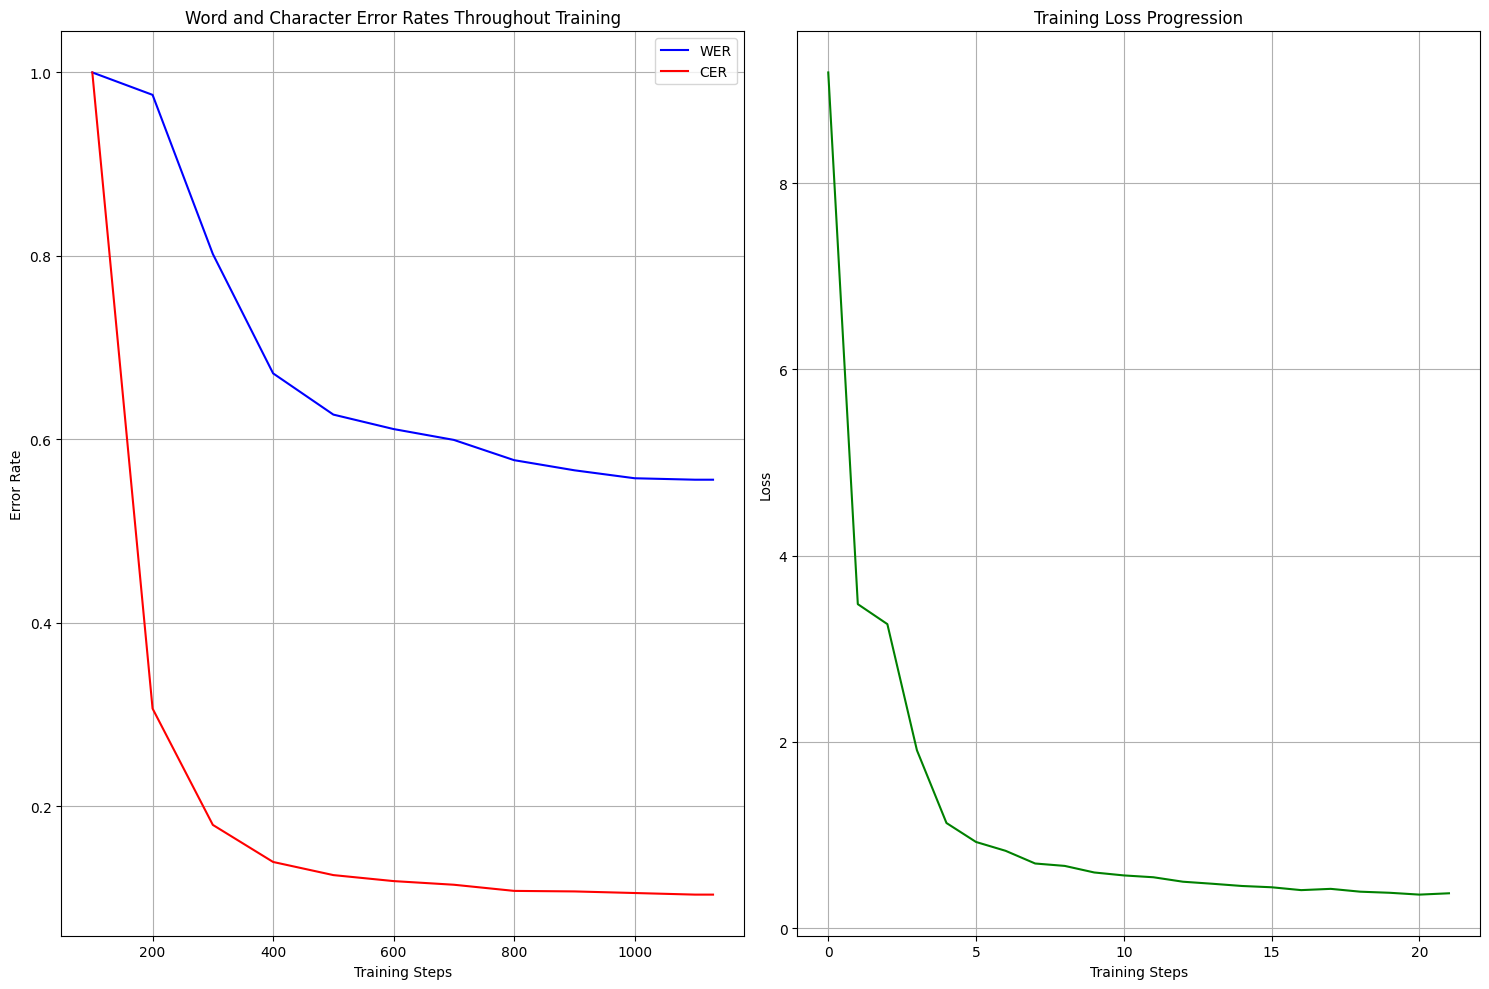

Saved prediction comparison to ./malayalam_hubert_output/sample_prediction.json
Could not save test sample: 'list' object has no attribute 'tolist'
Training and evaluation complete. Results saved to: ./malayalam_hubert_output


In [ ]:
  # ===== EVALUATION =====
print("Evaluating model...")
# Fix: Remove unsupported parameters
eval_results = trainer.evaluate(
    eval_dataset=malayalam_dataset["test"], 
    metric_key_prefix="eval"
)
print(f"Final evaluation results: {eval_results}")

# Make prediction on a test sample and compare with ground truth
print("\n===== PREDICTION EXAMPLE =====")
# Get a sample from the test set
sample = malayalam_dataset["test"][0]

# Fix: Get model's device and ensure input tensor is on the same device
device = model.device
# Convert to float16 (for mixed precision) and move to the correct device
input_values = torch.tensor(sample["input_values"], dtype=torch.float16).unsqueeze(0).to(device)

# Make prediction
with torch.no_grad():
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

# Decode the prediction and ground truth
predicted_text = processor.batch_decode(predicted_ids)[0]
ground_truth = processor.decode(sample["labels"], group_tokens=False)

# Display the comparison
print("Prediction:", predicted_text)
print("Ground Truth:", ground_truth)

# Plot final metrics
plt.figure(figsize=(15, 10))

# WER and CER
plt.subplot(1, 2, 1)
plt.plot(steps, eval_metrics['wer'], 'b-', label='WER')
plt.plot(steps, eval_metrics['cer'], 'r-', label='CER')
plt.xlabel('Training Steps')
plt.ylabel('Error Rate')
plt.title('Word and Character Error Rates Throughout Training')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(len(training_loss)), training_loss, 'g-')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Progression')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'final_metrics.png'))
plt.show()

# Save prediction comparison to file
prediction_output = os.path.join(output_dir, 'sample_prediction.json')
with open(prediction_output, 'w') as f:
    json.dump({
        'prediction': predicted_text,
        'ground_truth': ground_truth
    }, f)
print(f"Saved prediction comparison to {prediction_output}")

# Save final model to Kaggle-accessible path
final_model_path = os.path.join(output_dir, 'final_model')
os.makedirs(final_model_path, exist_ok=True)
model.save_pretrained(final_model_path)
processor.save_pretrained(final_model_path)

# Save a sample for quick testing
try:
    test_sample = malayalam_dataset["test"][0]
    test_sample_path = os.path.join(output_dir, 'test_sample.json')
    with open(test_sample_path, 'w') as f:
        json.dump({
            'input_values': test_sample['input_values'][:100].tolist(),  # Save just a snippet
            'labels': test_sample['labels'].tolist()
        }, f)
    print(f"Saved test sample to {test_sample_path}")
except Exception as e:
    print(f"Could not save test sample: {e}")

print("Training and evaluation complete. Results saved to:", output_dir)




## **1. HuBERT Model Inference**
### **Key Observations**
- **Final WER**: 0.556
- **Final CER**: 0.103
- **Loss Curve**: The loss starts high (~9) and steadily decreases, converging around 0.5. The curve indicates stable training.
- **WER and CER Curves**:
  - Both metrics show a consistent downward trend. The WER stabilizes around **0.55**, while the CER reaches **0.10**, indicating improved character-level accuracy.
- **Prediction Example**: Shows promising alignment with the ground truth, though still some errors persist.

### **Key Takeaways**
- The model demonstrates reasonable performance with a **WER of 55.6%**, suggesting moderate success in word-level recognition.
- The **CER of 10.3%** reflects better performance in character recognition, meaning the model performs well with smaller units (characters).

In [ ]:
import shutil
import os

def clear_kaggle_working():
    working_dir = "/kaggle/working"
    
    # List all files and folders in the directory
    for item in os.listdir(working_dir):
        item_path = os.path.join(working_dir, item)
        
        # Remove files or directories
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

    print("Cleared the /kaggle/working directory successfully.")

clear_kaggle_working()

Cleared the /kaggle/working directory successfully.
